<h1 align='center'>ML 2 Train</h1>

In [1]:
import pandas as pd
import numpy as np
import math

import sklearn as skl
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt

In [2]:
# validation function
def validate_model(model_type, param_grid, x_train, y_train, x_validate, y_validate):
    # Special case for LinearRegression because it doesn't have hyperparameters to tune
    if model_type == LinearRegression:
        model = LinearRegression()
        model.fit(x_train, y_train)
        pred = model.predict(x_validate)
        r2 = r2_score(y_validate, pred)
        
        return r2
    else: # The other cases
        
        # Establishses the ParameterGrid
        model_param_grid = ParameterGrid(param_grid)
        
        # Initialize values
        best_MAE = 0
        best_r2 = 1
        best_config = None
        # Iterate through the parameter grid, fit models to the hyperparameters
        # and check for MAE and R2 values
        
        # each param_config in that validation function would represent 1 combination of the possible parameters.
        # for example in Lab 6, when I'm validating for the elastic net regression, I have 
        # 2 possible hyperparameters: alpha and l1_ratio. 
        #alpha can take on values 0.0001, 0.0005, etc, and l1_ratio can take on values 0, 1, 0.01. 
        #So each param_config in the for loop in validate_model would go over 1 possible 
        #combination of the hyperparameter and keep the one that gives us the best MAE/R2
        for param_config in model_param_grid:
            curr_config_MAEs = []
            model = model_type(**param_config)
            model.fit(x_train, y_train)
            pred = model.predict(x_validate)
            MAE = mean_squared_error(y_validate,pred)
            r2 = r2_score(y_validate, pred)
            curr_config_MAEs.append(MAE)
            if best_MAE == 0 or (MAE < best_MAE):
                best_MAE = MAE
                best_config = param_config
            if best_r2 == 1 or (r2 > best_r2):
                best_r2 = r2
        return best_config, best_MAE, best_r2

In [3]:
# Predictions
def pred(model_type, x_train, y_train, x_test, y_test):
    # Fit model and predict 
    model = model_type.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    # Format prediction as DataFrame
    pred_df = pd.DataFrame(pred, columns = ['RET_pred'])
    pred_df.set_index(x_test.index, inplace = True)
    
    r2 = r2_score(y_test, pred)
    return pred_df, r2

In [4]:
train = pd.read_csv("train.csv")

In [5]:
valid = pd.read_csv("valid.csv")

In [6]:
total = pd.concat([train, valid], axis=0)

In [7]:
train, valid, test = \
                        np.split(total.sample(frac=1, random_state=42), 
                        [int(.6*len(total)), int(.8*len(total))])

In [8]:
x_train = train[['VOL', 'SPREAD', 'sizeln', 's2p', 'epspxq']]
y_train = train['risk_premium']

x_validate = valid[['VOL', 'SPREAD', 'sizeln', 's2p', 'epspxq']]
y_validate = valid['risk_premium']

x_test = test[['VOL', 'SPREAD', 'sizeln', 's2p', 'epspxq']]
y_test = test['risk_premium']

In [9]:
# Initialize the dictionary for the parameter grid
en_grid = dict()
# Set the parameter grid
en_grid['alpha'] = [0.0001,0.0005,0.001,0.005, 0.01,0.05,0.1]
en_grid['l1_ratio'] = np.arange(0, 1, 0.01)

# Run the validation
en_best_config, en_best_MAE, en_best_r2 = validate_model(ElasticNet, en_grid, x_train, y_train, x_validate\
                                                         , y_validate)

# To avoid convergence warnings, we can either 
# 1) set the tolerance higher (to require a less strict convergence requirement) or
# 2) increase the maximum number of iterations we allow

# There is no guarantee that we will get convergence when we fit a model, we can only 
# decide to cut off after a certain point

print('Best Config' + str(en_best_config))
print('Validation R2: '+ str(en_best_r2))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e+02, tolerance: 3.679e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e+02, tolerance: 3.679e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.

Best Config{'alpha': 0.01, 'l1_ratio': 0.06}
Validation R2: 0.00029800209302122127


In [10]:
factors = ['VOL', 'SPREAD', 'sizeln', 's2p', 'epspxq']
pls_grid = dict()
pls_grid['n_components'] = np.arange(1, len(factors)+1, 1)

pls_best_config, pls_best_MAE, pls_best_r2 = validate_model(PLSRegression, pls_grid, x_train, y_train, x_validate\
                                                            , y_validate)
print('Best config:' + str(pls_best_config))
print('Validation R2: ' + str(pls_best_r2))

Best config:{'n_components': 1}
Validation R2: 0.0002755757789726365


In [11]:
# Run the validation for the Linaer Regression
slr_r2_score = validate_model(LinearRegression, 1, x_train, y_train, x_validate, y_validate)

In [12]:
slr_vali_pred_df, slr_vali_r2 = pred(LinearRegression(), x_train, y_train, x_validate, y_validate)
pls_vali_pred_df, pls_vali_r2 = pred(ElasticNet(l1_ratio = 0.32, alpha = 0.0001),\
                                     x_train, y_train, x_validate, y_validate)
en_vali_pred_df, en_vali_r2 = pred(PLSRegression(2), x_train, y_train, x_validate, y_validate)

Text(0.5, 1.0, 'Actual returns vs predicted returns (validation set), SLR')

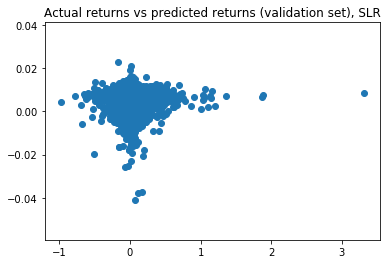

In [13]:
plt.scatter(y_test.sort_index(), slr_vali_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs predicted returns (validation set), SLR')

Text(0.5, 1.0, 'Actual returns vs predicted returns (validation set), PLS')

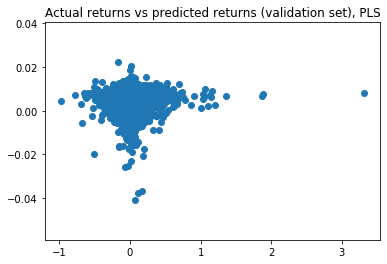

In [14]:
plt.scatter(y_test.sort_index(), pls_vali_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs predicted returns (validation set), PLS')

Text(0.5, 1.0, 'Actual returns vs predicted returns (validation set), EN')

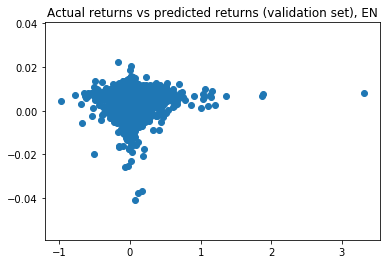

In [15]:
plt.scatter(y_test.sort_index(), pls_vali_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs predicted returns (validation set), EN')